In [ ]:
# given field position, yard line, down, dist
# give prob(success) >half/distance
# give formation most likely of the successes
# find range of yards with prediction from rf

In [159]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler # normalizing

# plots
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [162]:
# load data and model
data = pd.read_pickle('data.pkl')
# trained model
rf = pd.read_pickle('rf_model.sav')
trainX = pd.read_pickle('trainX.pkl')
testX = pd.read_pickle('testX.pkl')

In [163]:
# label bins need to be in integers for neural network to get dummy variables for the label array
bin_int = {'-10 or less':0,
           '-9 to -4':1,
           '-3 to -1':2,
           '0 to 3':3,
           '4 to 7':4,
           '8 to 10':5,
           '11 to 15':6,
           '16 to 25':7,
           '26+':8}
data['yards_bin_int'] = data['yards_binned'].map(bin_int)
bin_yard_names = list(bin_int.keys())
# get labels
bin_trainy = data.loc[data['season'] != 2019]['yards_bin_int']
bin_testY = data.loc[data['season'] == 2019]['yards_bin_int']

In [164]:
data = data.fillna(-999)
scaler = MinMaxScaler()
norm_data = scaler.fit_transform(data[list(trainX.columns)])

In [165]:
team_dict = {'ARZ': 'ARI',
            'CLV': 'CLE',
            'BLT':'BAL',
            'HST':'HOU'}
#map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
for abb in data['hometeamabbr'].unique():
    team_dict[abb] = abb

In [166]:
data['fieldposition'] = data['fieldposition'].map(team_dict)

In [167]:
# need to get a single field position variable
data['ownside'] = 0
data['ownside'].loc[data['possessionteam'] == data['fieldposition']] = 1 
#data['own'] = own_field(data['possessionteam'], data['fieldposition'])
#data[['possessionteam', 'fieldposition']].apply(own_field,axis = 1)

In [174]:
#from collections import defaultdict, Counter # for the model

def play_to_choose():
    # check that down input is valid
    down = input('Enter the down of the play (1 - 4): ')
    try:
        down = int(down)
        if (down <= 4) and (down >= 1):
            down = down
        else:
            return print('Please enter a valid down')
    except:
        return print('Please enter a valid down.')
    # check that ownside is valid
    ownside = input('Are you on your side of the field? (Y/N): ')
    try:
        if (ownside == 'Y') or (ownside == 'y'):
            ownside = 1
        elif (ownside == 'N') or (ownside == 'n'):
            ownside = 0
        else:
            return print('Please enter a Y or N.')
    except:
        return print('Please enter a Y or N.')
    # check yardline is valid
    yardline = input('Enter the yardline as an integer(1 - 50): ')
    try:
        yardline = int(yardline)
    except:
        return print('Please enter a valid yardline.')
    # check that distance is valid
    distance = input('Enter the distance for a first down as an integer(1 - 99): ')
    try:
        distance = int(distance)
    except:
        return print('Please enter a valid distance.')
    
    print('\nThanks for your input. Finding likely scenarios...')
    # check the scenario is in the data
    
    #try:
    df = data[(data['down'] == down)&(data['ownside'] == ownside)&(data['yardline'] == yardline)&(data['distance'] == distance)]       
    # normalize for prediction
    rf_df = scaler.fit_transform(df[list(trainX.columns)])
    if rf_df.shape[0] == 0:
        return print('Those play conditions are not in our data.')
    #except:
     #   if df.shape[0] == 0:
      #      return print('Those play conditions are not in our data.')
    # predict yards with random forest
    y_pred = rf.predict(rf_df)
    for rng, bucket in bin_int.items():
        if bucket == y_pred[0]:
            pred = rng
    # get some play metrics
    runsuccess_prob = round(df['runsuccess'].sum()/len(df)*100,2)
    avg_yards = round(df['yards'].mean(),2)
    off_form = df['offenseformation'].value_counts().index[0]
    off_pers = df['offensepersonnel'].value_counts().index[0]
    # first down freq
    first = 0
    # td freq
    td = 0
    # loss of yards
    loss = 0
    # long run >13.5 yds
    long = 0
    for index, row in df.iterrows():
        if row['distance'] <= row['yards']:
            first += 1
        if (100 - row['yardfromowngoal']) <= row['yards']:
            td += 1
        if row['yards'] < 0:
            loss = 0
        if row['yards'] > 13.5:
            long += 1
    # first down probability
    first_pct = round(first/len(df)*100,2)
    # touchdown probability
    td_pct = round(td/len(df)*100,2)
    # loss probability
    loss_pct = round(loss/len(df)*100,2)
    # long run probability
    long_pct = round(long/len(df)*100,2)
    print('\nPredicted Yards Gained: ', pred)
    #print('\nLikelihood of gaining half the required yards: ', runsuccess_prob, '%')
    #print('\nLikelihood of a first down: ', first_pct, '%')
    #print('\nLikelihood of a touchdown: ', td_pct, '%')
    print('\nAverage Yards Gained: ', avg_yards)
    print('\nMost Common Offensive Formation: ', off_form)
    print('\nMost Common Offensive Personnel: ', off_pers)
    names = ['Run Success', 'First Down', 'TD', 'Long Run (>13.5)','Loss of Yards']
    stats = pd.DataFrame([runsuccess_prob, first_pct, td_pct ,long_pct, loss_pct], columns = ['stats'])
    stats['names'] = names
    sns.barplot(x = 'names', y = 'stats', data = stats, color = 'tab:blue')
    for i in np.arange(2):
        plt.text(x = i,
                y = stats['stats'][i]-10,
                s = str(stats['stats'][i]) + '%',
                color = 'white',
                horizontalalignment='center')
    for i in np.arange(2,5):
        plt.text(x = i,
                y = stats['stats'][i]+2,
                s = str(stats['stats'][i]) + '%',
                horizontalalignment='center')
    plt.xlabel('Play Outcomes')
    plt.xticks(rotation = 30)
    plt.ylabel('')
    plt.title('Likelihood of Play Outcomes')
    #return stats.head()
    
    

# Interactive for Coaches
1. Press Shift+Enter to run the command below
2. Follow the prompts, pressing enter after each input
3. Enjoy the results!

Enter the down of the play (1 - 4): 2
Are you on your side of the field? (Y/N): y
Enter the yardline as an integer(1 - 50): 30
Enter the distance for a first down as an integer(1 - 99): 6

Thanks for your input. Finding likely scenarios...

Predicted Yards Gained:  0 to 3

Average Yards Gained:  5.99

Most Common Offensive Formation:  SINGLEBACK

Most Common Offensive Personnel:  1 RB, 2 TE, 2 WR


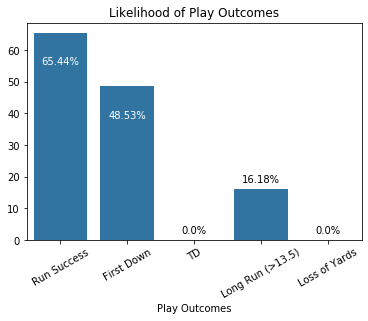

In [175]:
play_to_choose()